In [13]:


# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib import patches
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.

# TOLERANCE = 0.15
TOLERANCE = 0.05


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes, k=1):
        self.i = 0
        self.k = k
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

        self.adding_points_toScene = False
        self.added_points_toScene = []
        self.adding_lines_toScene = False
        self.added_lines_toScene = []
        self.adding_rects_toScene = False
        self.added_rects_toScene = []



    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def changeScene(self, event, gap):
        self.adding_lines = False
        self.adding_rects = False
        self.adding_points = False
        self.adding_points_toScene = False
        self.adding_lines_toScene = False
        self.adding_rects_toScene = False

        self.i = (self.i + gap) % max(len(self.scenes), 1)
        self.draw(autoscaling=True)

    def next(self, event):
        self.changeScene(event, 1)

    def next_10(self, event):
        self.changeScene(event, 10)


    def next_100(self, event):
        self.changeScene(event, 100)



    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.changeScene(event, -1)


    def prev_10(self, event):
        self.changeScene(event, -10)


    def prev_100(self, event):
        self.changeScene(event, -100)


    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False

            self.adding_points_toScene = False
            self.adding_lines_toScene = False
            self.adding_rects_toScene = False

            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False

            self.adding_points_toScene = False
            self.adding_lines_toScene = False
            self.adding_rects_toScene = False

            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False

            self.adding_points_toScene = False
            self.adding_lines_toScene = False
            self.adding_rects_toScene = False

            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
#MyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMy
    def add_point_toScene(self, event):
        self.adding_points_toScene = not self.adding_points_toScene
        self.new_line_point = None
        if self.adding_points_toScene:
            self.adding_points = False
            self.adding_lines = False
            self.adding_rects = False

            self.adding_lines_toScene = False
            self.adding_rects_toScene = False

            self.scenes[self.i].points.append(PointsCollection([]))

    def add_line_toScene(self, event):
        self.adding_lines_toScene = not self.adding_lines_toScene
        self.new_line_point = None
        if self.adding_lines_toScene:
            self.adding_points = False
            self.adding_lines = False
            self.adding_rects = False

            self.adding_points_toScene = False
            self.adding_rects_toScene = False

            self.scenes[self.i].lines.append(LinesCollection([]))

    def add_rect_toScene(self, event):
        self.adding_rects_toScene = not self.adding_rects_toScene
        self.new_line_point = None
        if self.adding_rects_toScene:
            self.adding_points = False
            self.adding_lines = False
            self.adding_rects = False

            self.adding_points_toScene = False
            self.adding_lines_toScene = False

            self.new_rect_toScene()

    def new_rect_toScene(self):
        self.scenes[self.i].lines.append(LinesCollection([]))
        self.rect_points = []

    def addScene(self, event):
        self.scenes.append(Scene())
        self.changeScene(event, 0)
        self.i = len(self.scenes) - 1
        self.draw(autoscaling=False)

    def delScene(self, event):
        if len(self.scenes) > 1:
            del self.scenes[self.i]
            self.i = min(self.i, len(self.scenes) - 1)
            self.draw(autoscaling=False)
        else:
            self.scenes[0].points = []
            self.scenes[0].lines = []

        self.changeScene(event, 0)


    # MyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMyMy

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_points_toScene:
            self.scenes[self.i].points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_lines_toScene:
            if self.new_line_point is not None:
                self.scenes[self.i].lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.added_rects[-1].isPolygon = True
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)
        elif self.adding_rects_toScene:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.scenes[self.i].lines[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.scenes[self.i].lines[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.scenes[self.i].lines[-1].isPolygon = True
                    self.new_rect_toScene()
                else:
                    self.scenes[self.i].lines[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        ##########################
        self.ax._axes.set_title(self.scenes[self.i].title + f"\nscene {str(self.i+1)}/{len(self.scenes)}")
        for patch in self.scenes[self.i].patches:
            self.ax.add_patch(patch)
        ##########################
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.


class Scene:
    def __init__(self, points=None, lines=None, patches=None, title=""):
        if points is None:
            points = []
        if lines is None:
            lines = []
        if patches is None:
            patches = []
        self.points = points
        self.lines = lines
        self.title = title
        self.patches = patches

    def getAllLines(self):
        L = []
        for linesColl in self.lines:
            L += linesColl.lines
        return L
    def getAllPoints(self):
        V = []
        for pointsColl in self.points:
            V += pointsColl.points
        return V


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points
    def getPointsAsList(self):
        return self.points.copy()

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, isPolygon=False, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        self.isPolygon = isPolygon

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    def getLinesAsList(self):
        return self.lines.copy()

    def getPointsOfPolygon(self):
        if not self.isPolygon:
            print("It is not polygon")
            return None
        return [v for (v, _) in self.lines]

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=None, points=None, lines=None, json=None):
        if not scenes:
            scenes = [Scene()]
        if points == None:
            points = []
        if lines == None:
            lines = []

        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol[0], **pointsCol[1]) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol[0], linesCol[1], **linesCol[2]) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.07, 0.15, 0.055])
        ax_next = plt.axes([0.76, 0.07, 0.15, 0.055])
        ax_add_point = plt.axes([0.44, 0.07, 0.15, 0.055])
        ax_add_line = plt.axes([0.28, 0.07, 0.15, 0.055])
        ax_add_rect = plt.axes([0.12, 0.07, 0.15, 0.055])

        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)

        ax_prev10 = plt.axes([0.6, 0.035, 0.15, 0.025])
        ax_next10 = plt.axes([0.76, 0.035, 0.15, 0.025])
        b_next10 = Button(ax_next10, '10')
        b_prev10 = Button(ax_prev10, '10')
        b_next10.on_clicked(self.callback.next_10)
        b_prev10.on_clicked(self.callback.prev_10)

        ax_prev100 = plt.axes([0.6, 0.001, 0.15, 0.025])
        ax_next100 = plt.axes([0.76, 0.001, 0.15, 0.025])
        b_next100 = Button(ax_next100, '100')
        b_prev100 = Button(ax_prev100, '100')
        b_next100.on_clicked(self.callback.next_100)
        b_prev100.on_clicked(self.callback.prev_100)

        ax_add_point_toScene = plt.axes([0.44, 0.001, 0.15, 0.06])
        ax_add_line_toScene = plt.axes([0.28, 0.001, 0.15, 0.06])
        ax_add_rect_toScene = plt.axes([0.12, 0.001, 0.15, 0.06])
        b_add_point_toScene = Button(ax_add_point_toScene, 'Dodaj punkt\n do sceny')
        b_add_point_toScene.on_clicked(self.callback.add_point_toScene)
        b_add_line_toScene = Button(ax_add_line_toScene, 'Dodaj linię\n do sceny')
        b_add_line_toScene.on_clicked(self.callback.add_line_toScene)
        b_add_rect_toScene = Button(ax_add_rect_toScene, 'Dodaj figurę\n do sceny')
        b_add_rect_toScene.on_clicked(self.callback.add_rect_toScene)

        ax_addScene = plt.axes([0.92, 0.07, 0.07, 0.06])
        b_addScene = Button(ax_addScene, 'Nowa \nscena')
        b_addScene.on_clicked(self.callback.addScene)

        ax_delScene = plt.axes([0.92, 0.005, 0.07, 0.06])
        b_delScene = Button(ax_delScene, 'Usuń \nscenę')
        b_delScene.on_clicked(self.callback.delScene)

        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect,
                b_prev10, b_next10, b_next100, b_prev100,
                b_add_point_toScene, b_add_line_toScene, b_add_rect_toScene,
                b_addScene, b_delScene
                ]


############################
    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [[np.array(pointCol.points).tolist(), pointCol.kwargs] for pointCol in scene.points],
                          "lines": [[linesCol.lines, linesCol.isPolygon, linesCol.kwargs] for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()




In [14]:
%matplotlib notebook

QUAD_0_EPSILON = 0.1


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        if isinstance(other, self.__class__) and (self.x == other.x and self.y == other.y):
            return True
        return False

    def __str__(self):
        return "(" + str(round(self.x, 3)) + ", " + str(round(self.y, 3)) + ")"

    def __repr__(self):
        return self.__str__()


class Rect:
    def __init__(self, x1=0, x2=0, y1=0, y2=0):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.mid = Point((x2 + x1) / 2, (y2 + y1) / 2)

    def normalizeToSquare(self):
        x1 = self.x1
        x2 = self.x2
        y1 = self.y1
        y2 = self.y2
        sideLength = max(x2 - x1, y2 - y1)
        if sideLength == x2 - x1:
            self.y1 -= (sideLength - (y2 - y1)) / 2
            self.y2 = y1 + sideLength
        else:
            self.x1 -= (sideLength - (x2 - x1)) / 2
            self.x2 = x1 + sideLength

        self.mid = Point((self.x2 + self.x1) / 2, (self.y2 + self.y1) / 2)


    def getListOfSides(self):
        x1 = self.x1
        x2 = self.x2
        y1 = self.y1
        y2 = self.y2

        sides = [[(x1, y1), (x2, y1)],
                 [(x2, y1), (x2, y2)],
                 [(x2, y2), (x1, y2)],
                 [(x1, y2), (x1, y1)]]
        return sides

    def getSplittingLines(self):
        lines = [[(self.mid.x, self.y1), (self.mid.x, self.y2)],
                 [(self.x1, self.mid.y), (self.x2, self.mid.y)]]
        return lines

    def contains(self, p):
        return self.x1 <= p.x and p.x <= self.x2 and self.y1 <= p.y and p.y <= self.y2

    def include(self, rect):
        return self.x1 <= rect.x1 and rect.x2 <= self.x2 and self.y1 <= rect.y1 and rect.y2 <= self.y2

    def containsInner(self, p):
        return self.x1 < p.x and p.x < self.x2 and self.y1 < p.y and p.y < self.y2

    def _containsCorner(self, rect, f):
        return f(self, Point(rect.x1, rect.y1)) \
               or f(self, Point(rect.x2, rect.y1)) \
               or f(self, Point(rect.x2, rect.y2)) \
               or f(self, Point(rect.x1, rect.y2))

    def isIntersecting(self, rect):
        f = lambda r, p: r.contains(p)
        return self._containsCorner(rect, f) or rect._containsCorner(self, f)

    def isIntersectingInternally(self, rect):
        f = lambda r, p: r.containsInner(p)
        return self._containsCorner(rect, f) or rect._containsCorner(self, f)



class Quad(Rect):
    def __init__(self, x1, x2, y1, y2):
        super().__init__(x1, x2, y1, y2)



class QTNode:
    def __init__(self, quad, isLeaf=False):
        self.isLeaf = isLeaf
        self.quad = quad
        self.SW = None
        self.SE = None
        self.NE = None
        self.NW = None
        self.points = [] if isLeaf else None

    def getDepth(self):
        if self.isLeaf:
            return 1
        else:
            currDepth = 0
            currDepth = max(currDepth, self.SW.getDepth() + 1)
            currDepth = max(currDepth, self.SE.getDepth() + 1)
            currDepth = max(currDepth, self.NE.getDepth() + 1)
            currDepth = max(currDepth, self.NW.getDepth() + 1)
            return currDepth

    def _search(self, queryRect, repPoints):
        if self.isLeaf:
            for p in self.points:
                if queryRect.contains(p):
                    repPoints.append(p)
        else:
            if queryRect.isIntersecting(self.SW.quad):
                self.SW._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.SE.quad):
                self.SE._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.NE.quad):
                self.NE._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.NW.quad):
                self.NW._search(queryRect, repPoints)

    def reportAllRec(self, repPoints):
        if self.isLeaf:
            repPoints += self.points
        else:
            self.SW.reportAll(repPoints)
            self.SE.reportAll(repPoints)
            self.NE.reportAll(repPoints)
            self.NW.reportAll(repPoints)

    def instantReportAll(self):
        return self.points


    def _searchWithConsiInclusions(self, queryRect, repPoints):
        if self.isLeaf:
            for p in self.points:
                if queryRect.contains(p):
                    repPoints.append(p)
        else:
            if queryRect.isIntersecting(self.SW.quad):
                if queryRect.include(self.SW.quad):
                    rep = self.SW.instantReportAll()
                    if rep is not None:
                        repPoints += rep
                    else:
                        self.SW.reportAllRec(repPoints)
                else:
                    self.SW._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.SE.quad):
                if queryRect.include(self.SE.quad):
                    rep = self.SE.instantReportAll()
                    if rep is not None:
                        repPoints += rep
                    else:
                        self.SE.reportAllRec(repPoints)
                else:
                    self.SE._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.NE.quad):
                if queryRect.include(self.NE.quad):
                    rep = self.NE.instantReportAll()
                    if rep is not None:
                        repPoints += rep
                    else:
                        self.NE.reportAllRec(repPoints)
                else:
                    self.NE._search(queryRect, repPoints)
            if queryRect.isIntersecting(self.NW.quad):
                if queryRect.include(self.NW.quad):
                    rep = self.NW.instantReportAll()
                    if rep is not None:
                        repPoints += rep
                    else:
                        self.NW.reportAllRec(repPoints)
                else:
                    self.NW._search(queryRect, repPoints)
        pass


class QuadTree:
    def __init__(self, P=None, quad_0=None, nodeCapacity=1, eachNodeContainsPoints=False):
        if P is None and quad_0 is None:
            raise ValueError
        self.nodeCapacity = nodeCapacity
        if P is not None and len(P) > 0 and not isinstance(P[0], Point):
            P = [Point(x, y) for (x, y) in P]
        if P is None:
            P = []
        self.P = P

        if quad_0 is None:
            x1 = min(P, key=lambda p: p.x).x - QUAD_0_EPSILON
            x2 = max(P, key=lambda p: p.x).x + QUAD_0_EPSILON
            y1 = min(P, key=lambda p: p.y).y - QUAD_0_EPSILON
            y2 = max(P, key=lambda p: p.y).y + QUAD_0_EPSILON
            quad_0 = Quad(x1, x2, y1, y2)
            quad_0.normalizeToSquare()

        def constructQuadTree(quad, P):

            if len(P) <= self.nodeCapacity:
                v = QTNode(quad=quad, isLeaf=True)
                v.points = P
                return v
            else:
                quad_SW = Quad(quad.x1, quad.mid.x, quad.y1, quad.mid.y)
                quad_SE = Quad(quad.mid.x, quad.x2, quad.y1, quad.mid.y)
                quad_NE = Quad(quad.mid.x, quad.x2, quad.mid.y, quad.y2)
                quad_NW = Quad(quad.x1, quad.mid.x, quad.mid.y, quad.y2)

                P_SW = []
                P_SE = []
                P_NE = []
                P_NW = []
                for p in P:
                    if p.x <= quad.mid.x:
                        if p.y <= quad.mid.y:
                            P_SW.append(p)
                        else:
                            P_NW.append(p)
                    else:
                        if p.y <= quad.mid.y:
                            P_SE.append(p)
                        else:
                            P_NE.append(p)
                v_SW = constructQuadTree(quad_SW, P_SW)
                v_SE = constructQuadTree(quad_SE, P_SE)
                v_NE = constructQuadTree(quad_NE, P_NE)
                v_NW = constructQuadTree(quad_NW, P_NW)

                v = QTNode(quad=quad, isLeaf=False)
                if eachNodeContainsPoints:
                    v.points = P
                v.SW = v_SW
                v.SE = v_SE
                v.NE = v_NE
                v.NW = v_NW

                return v

        self.root = constructQuadTree(quad=quad_0, P=P)

    def calculateDepth(self):
        return self.root.getDepth()

    def searchInRange(self, queryRect):
        reportedPoints = []
        self.root._search(queryRect, reportedPoints)
        return reportedPoints

    def searchInRangeWithConsiInclusions(self, queryRect):
        reportedPoints = []
        self.root._searchWithConsiInclusions(queryRect, reportedPoints)
        return reportedPoints



[(3.393, 3.735), (3.861, 4.151), (4.438, 4.762), (4.308, 4.687), (3.497, 4.078), (3.72, 4.328), (6.011, 3.306), (5.495, 3.403), (6.345, 4.19), (6.488, 4.325), (5.363, 4.314), (5.36, 5.14), (5.371, 5.867), (6.896, 5.062), (6.476, 5.7), (3.061, 5.297), (2.911, 5.632), (3.719, 5.479), (2.74, 5.964)]
True


<IPython.core.display.Javascript object>


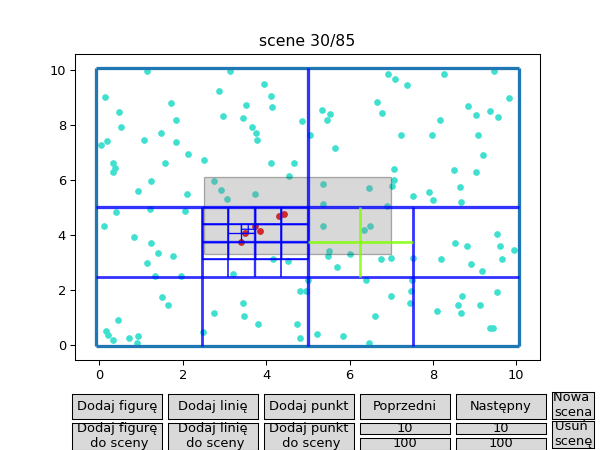

In [18]:
from random import uniform

class QuadTreeVis:
    def __init__(self, quadTree):
        self.quadTree = quadTree
        self.colors = {'initPoint': 'orange',
                       'normalPoint': 'turquoise',
                       'reportedPoint': 'red',
                       'normalLine': 'blue',
                       'activeLine': 'chartreuse',
                       'queryRectFill': 'grey',
                       'queryRectEdge': 'black',
                       'alphaLine': 0.80}

    def makeConsecutiveScenes(self, consecutiveElements, patches=None):
        sides0 = qt.root.quad.getListOfSides()
        scenes = []
        points0 = [[p.x, p.y] for p in qt.P]
        reportedPoints = []
        maxDepth = self.quadTree.calculateDepth()
        lineWidth0 = 2.5
        pointSize = 17
        prevLines = [LinesCollection(lines=sides0, linewidth=lineWidth0)]

        scenes.append(Scene(points=[PointsCollection(points=points0, color=self.colors['initPoint'], s=pointSize)],
                            lines=[LinesCollection(lines=sides0, alpha=self.colors['alphaLine'])]))

        for el in consecutiveElements:
            reportedPoints = reportedPoints + [[p.x, p.y] for p in el['points']]
            scenes.append(
                Scene(points=[PointsCollection(points=points0, color=self.colors['normalPoint'], s=pointSize),
                              PointsCollection(points=reportedPoints, color=self.colors['reportedPoint'], s=pointSize)],
                      lines=prevLines + [
                          LinesCollection(lines=el['lines'], color=self.colors['activeLine'],
                                          linewidth=lineWidth0 * (maxDepth - el['depth'] / 2) / maxDepth,
                                          alpha=self.colors['alphaLine'])])
            )
            prevLines = prevLines + [LinesCollection(lines=el['lines'],
                                                     linewidth=lineWidth0 * (maxDepth - el['depth']) / maxDepth,
                                                     color=self.colors['normalLine'],
                                                     alpha=self.colors['alphaLine'])]
        scenes.append(
            Scene(points=[PointsCollection(points=reportedPoints, color=self.colors['reportedPoint'], s=pointSize)],
                  lines=prevLines)
        )
        if patches is not None:
            for s in scenes:
                s.patches = patches


        return scenes


    def getInitVis(self):
        consecutiveElements = []
        qt = self.quadTree

        def addConsElements(v: QTNode, conEl, depth):
            if v.isLeaf:
                conEl.append({'depth': depth, 'lines': v.quad.getListOfSides(), 'points': v.points})

            else:
                conEl.append({'depth': depth, 'lines': v.quad.getSplittingLines(), 'points': []})
                addConsElements(v.SW, conEl, depth + 1)
                addConsElements(v.SE, conEl, depth + 1)
                addConsElements(v.NE, conEl, depth + 1)
                addConsElements(v.NW, conEl, depth + 1)


        addConsElements(qt.root, consecutiveElements, 0)

        scenes = self.makeConsecutiveScenes(consecutiveElements)

        return Plot(scenes=scenes)

    def getRangeQueryVis(self, queryRect: Rect):
        x = queryRect.x1
        y = queryRect.y1
        dx = queryRect.x2 - queryRect.x1
        dy = queryRect.y2 - queryRect.y1
        queryRectVis = patches.Rectangle((x, y), dx, dy,
                                         edgecolor=self.colors['queryRectEdge'],
                                         facecolor=self.colors['queryRectFill'],
                                         alpha=0.3)

        def _search(v, queryRect, conEl, depth):
            if v.isLeaf:
                conEl.append({'depth': depth, 'lines': v.quad.getListOfSides(),
                              'points': list(filter(lambda p: queryRect.contains(p), v.points))})

            else:
                conEl.append({'depth': depth, 'lines': v.quad.getSplittingLines(), 'points': []})
                if queryRect.isIntersecting(v.SW.quad):
                    _search(v.SW, queryRect, conEl, depth+1)
                if queryRect.isIntersecting(v.SE.quad):
                    _search(v.SE, queryRect, conEl, depth+1)
                if queryRect.isIntersecting(v.NE.quad):
                    _search(v.NE, queryRect, conEl, depth+1)
                if queryRect.isIntersecting(v.NW.quad):
                    _search(v.NW, queryRect, conEl, depth+1)


        consecutiveElements = []
        _search(self.quadTree.root, queryRect, consecutiveElements, 0)
        scenes = self.makeConsecutiveScenes(consecutiveElements, patches=[queryRectVis])

        return Plot(scenes=scenes)


if __name__ == '__main__':
    m = 0
    M = 10
    n = 150

    P = [(uniform(m, M), uniform(m, M)) for _ in range(n)]
    # P = [Point(x, y) for (x, y) in pp]
    # print(P)
    qt = QuadTree(P=P)

    queryRect = Rect(2.5, 7, 3.3, 6.1)
    repP = qt.searchInRange(queryRect)
    repP2 = qt.searchInRangeWithConsiInclusions(queryRect)
    print(repP)
    print(len(repP) == len(repP2))

    qtVis = QuadTreeVis(qt)
    plotInit = qtVis.getInitVis()
#     plotInit.draw()
    plotSearch = qtVis.getRangeQueryVis(queryRect)
    plotSearch.draw()


